C:\Users\syf83691\AppData\Local\Temp\ipykernel_23528\1276432029.py:36: RuntimeWarning: divide by zero encountered in divide
  um = 1.0 / fxfinal


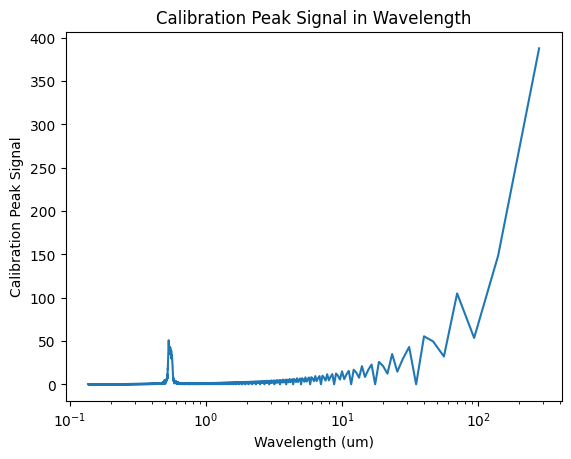

In [10]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

def regularspacing(yhene, Ndet, NFFT):
    yhenesmooth = median_filter(yhene, 2)
    xhene = np.arange(1, Ndet + 1)
    locs, _ = find_peaks(yhenesmooth)
    N = len(locs)
    ypos = locs

    xpos = np.linspace(ypos[0], ypos[-1], N)
    p = np.polyfit(xpos, ypos, 3)
    ypos_fit = np.polyval(p, xhene)
    yi = np.interp(xhene, ypos_fit, yhene)
    yinorm = (yi / np.max(yi)) * -1 + 1
    rnreal = np.roots(p)

    return yi, xhene, yinorm, rnreal.real

def newpeakfind(yhene, line_centre, Ndet):
    locs, _ = find_peaks(yhene)
    N = len(locs)
    xposnew = locs
    ypos = line_centre * np.arange(1, N + 1)
    newp = np.polyfit(xposnew, ypos, 2)
    NFFT = 2 ** int(np.ceil(np.log2(Ndet)))
    xcal = np.polyval(newp, np.arange(1, NFFT + 1))
    dx = np.diff(xcal)
    dx = np.append(dx, dx[-1])
    dx = dx[Ndet//2] # a line of code is missing here. Check Elin's matlab code. dx should become a scalar
    Fs = 1.0 / dx
    fxfinal = Fs / 2 * np.linspace(0, 1, int(NFFT / 2) + 1) #this doesn't work because Fs shouldn't be a list
    um = 1.0 / fxfinal

    return fxfinal, um

# Import calibration data
calibration_data = np.loadtxt('data\\henefordoubletsignal170216.txt')
xhene_calib = calibration_data[:, 0]
yhene_calib = calibration_data[:, 1]

# Import interferogram data
interferogram_data = np.loadtxt('data\\doubletsignal170216.txt')
xhene_interfero = interferogram_data[:, 0]
yhene_interfero = interferogram_data[:, 1]

pixelsize = 2.2
theta = 1.8
line_centre = 0.546

xaxiscalibpixel = 0
sin_theta_incident = np.sin(np.radians(theta))

B = yhene_calib
#B = B.reshape(-1, 1)
Ndet = len(B)
NFFT = 2 ** int(np.ceil(np.log2(Ndet)))
yi, xhene, yinorm, rnreal = regularspacing(B, Ndet, NFFT)

if xaxiscalibpixel == 0:
    fx, um = newpeakfind(yhene_calib, line_centre, Ndet)
else:
    pixelsize = 2.2
    Fs = 1 / pixelsize
    fx = Fs / 2 * np.linspace(0, 1, int(NFFT / 2) + 1)
    um1 = fx / (2 * sin_theta_incident)
    um = 1 / um1

Yc = np.fft.fft(yi, NFFT) / Ndet
B1 = 2 * np.abs(Yc[:NFFT // 2 + 1])
B2 = np.vstack((um, B1)).T

plt.plot(B2[:, 0], B2[:, 1])
plt.xlabel('Wavelength (um)')
plt.ylabel('Calibration Peak Signal')
plt.title('Calibration Peak Signal in Wavelength')
plt.xscale("log")
plt.show()
